<a href="https://colab.research.google.com/github/Fidelisaboke/robust-nids/blob/feat%2Fadversarial/notebooks/05_adversarial_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Training for Robust NIDS
This notebook implements FGSM and PGD adversarial attacks, evaluates a baseline XGBoost NIDS, trains a differentiable surrogate model, performs adversarial training (FGSM augmentation), and evaluates robustness across multiple epsilons.

**What it contains**:
- Setup (mount Google Drive, install packages)
- Load dataset + preprocessor + baseline model
- Train stronger surrogate (Keras MLP)
- Generate FGSM & PGD adversarial samples (multi-ε)
- Evaluate baseline and robust models (ASR, classification reports, mixed-set sanity check)
- Save results, plots, and robust model

Make sure the artifacts (preprocessor and baseline model) are in the specified paths before running.


## Mount Google Drive

In [33]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install or Upgrade Required Packages

In [34]:
# Install/upgrade required packages
!pip install --upgrade scikit-learn xgboost joblib


## Imports

In [35]:
# Imports
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Any

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.utils import shuffle as sk_shuffle


## Configuration

In [36]:
# Configuration
CONFIG = {
    'BASE_DIR': '/content/drive/MyDrive/Datasets/TII-SSRC-23/',
    'ARTIFACTS_DIR': 'Artifacts',
    'CLEAN_DATA': 'cleaned_data.csv',
    'BASELINE_PREPROCESSOR': 'Artifacts/binary_preprocessor.pkl',
    'BASELINE_MODEL': 'Artifacts/binary_xgboost.json',
    'ROBUST_MODEL_OUT': 'Artifacts/robust_binary_xgboost.json',
    'EXPERIMENT_RESULTS': 'Artifacts/adversarial_experiment.json',
    'EXPERIMENT_PLOT': 'Artifacts/adversarial_comparison.png',
    'RANDOM_STATE': 42,
    'SURROGATE_EPOCHS': 40,
    'SURROGATE_BATCH_SIZE': 256,
    'SURROGATE_VERBOSE': 1,
    'SURROGATE_LR': 1e-3,
    'PGD_ITERS': 10,
    'PGD_ALPHA_FACTOR': 0.25,
    'EPSILONS': [0.05, 0.1, 0.2],
    'USE_SCALE_POS_WEIGHT': False,
    'SAVE_PLOTS': True,
}

BASE_DIR = Path(CONFIG['BASE_DIR']).expanduser()
ARTIFACTS_DIR = BASE_DIR / CONFIG['ARTIFACTS_DIR']
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

PATHS = {
    'CLEAN_DATA': str(BASE_DIR / CONFIG['CLEAN_DATA']),
    'BASELINE_PREPROCESSOR': str(BASE_DIR / CONFIG['BASELINE_PREPROCESSOR']),
    'BASELINE_MODEL': str(BASE_DIR / CONFIG['BASELINE_MODEL']),
    'ROBUST_MODEL_OUT': str(BASE_DIR / CONFIG['ROBUST_MODEL_OUT']),
    'EXPERIMENT_RESULTS': str(BASE_DIR / CONFIG['EXPERIMENT_RESULTS']),
    'EXPERIMENT_PLOT': str(BASE_DIR / CONFIG['EXPERIMENT_PLOT']),
}

np.random.seed(CONFIG['RANDOM_STATE'])
tf.random.set_seed(CONFIG['RANDOM_STATE'])


## Utility Functions

In [37]:
# Utility functions to load artifacts
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'Data file not found: {path}')
    return pd.read_csv(path)

def load_preprocessor(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'Preprocessor not found: {path}')
    return joblib.load(path)

def load_xgb_model(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'XGBoost model not found: {path}')
    model = XGBClassifier()
    model.load_model(path)
    return model


## Load Data and Artifacts


In [38]:
# Load dataset and preprocessor and baseline model
df = load_data(PATHS['CLEAN_DATA'])
print(f'Loaded {len(df)} rows')

drop_cols = ['Label', 'Traffic Type', 'Traffic Subtype']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['Label'].values
y_multi = df['Traffic Type'].values if 'Traffic Type' in df.columns else None

preprocessor = load_preprocessor(PATHS['BASELINE_PREPROCESSOR'])
print('Loaded preprocessor')
baseline_xgb = load_xgb_model(PATHS['BASELINE_MODEL'])
print('Loaded baseline XGBoost model')


Loaded 235453 rows
Loaded preprocessor
Loaded baseline XGBoost model


## Train, Val, Test Split

In [39]:
stratify = y_multi if y_multi is not None else y
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=stratify, random_state=CONFIG['RANDOM_STATE'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=CONFIG['RANDOM_STATE'])
print('Shapes:')
print(X_train.shape, X_val.shape, X_test.shape)

# Apply preprocessor (do NOT refit)
X_train_scaled = preprocessor.transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)
print('Preprocessing applied.')


Shapes:
(164817, 81) (35318, 81) (35318, 81)
Preprocessing applied.


## Surrogate Model (Keras MLP)
This surrogate is differentiable and used to craft adversarial examples that transfer to the non-differentiable XGBoost baseline.


In [40]:
def create_surrogate_model(input_dim, lr=1e-3):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

print('Creating and training surrogate model...')
surrogate = create_surrogate_model(X_train_scaled.shape[1], lr=CONFIG['SURROGATE_LR'])
es = EarlyStopping(patience=5, restore_best_weights=True)
surrogate.fit(
    X_train_scaled, y_train,
    epochs=CONFIG['SURROGATE_EPOCHS'],
    batch_size=CONFIG['SURROGATE_BATCH_SIZE'],
    validation_data=(X_val_scaled, y_val),
    callbacks=[es],
    verbose=CONFIG['SURROGATE_VERBOSE']
)
print('Surrogate training complete')


Creating and training surrogate model...
Epoch 1/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.9591 - loss: 0.1427 - val_accuracy: 0.9953 - val_loss: 0.0179
Epoch 2/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.9968 - val_loss: 0.0135
Epoch 3/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9950 - loss: 0.0179 - val_accuracy: 0.9970 - val_loss: 0.0127
Epoch 4/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9959 - loss: 0.0163 - val_accuracy: 0.9971 - val_loss: 0.0118
Epoch 5/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9963 - loss: 0.0149 - val_accuracy: 0.9972 - val_loss: 0.0111
Epoch 6/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9961 - loss: 0.0145 - val_accuracy: 0.9973 - val_loss: 0.0105
Epoch 7/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.9973 - val_loss: 0.0098
Epoch 8/40
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accura

## Baseline Evaluation

In [41]:
# Baseline evaluation on clean test set
y_pred_xgb = baseline_xgb.predict(X_test_scaled)
acc_xgb_normal = accuracy_score(y_test, y_pred_xgb)
print(f'Baseline XGBoost Accuracy (Normal Data): {acc_xgb_normal*100:.2f}%')
print('Classification report:')
print(classification_report(y_test, y_pred_xgb, digits=4))


Baseline XGBoost Accuracy (Normal Data): 99.88%
Classification report:
              precision    recall  f1-score   support

           0     0.9889    0.9958    0.9923      2853
           1     0.9996    0.9990    0.9993     32465

    accuracy                         0.9988     35318
   macro avg     0.9942    0.9974    0.9958     35318
weighted avg     0.9988    0.9988    0.9988     35318



## Surrogate Evaluation

In [42]:
# Surrogate evaluation on clean test set
y_pred_surr = (surrogate.predict(X_test_scaled) > 0.5).astype(int)
acc_surr_normal = accuracy_score(y_test,y_pred_surr)
print(f'Suorrogate Accuracy (Normal Data): {acc_surr_normal*100:.2f}%')
print('Classification report:')
print(classification_report(y_test, y_pred_surr, digits=4))

1104/1104 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Suorrogate Accuracy (Normal Data): 99.78%
Classification report:
              precision    recall  f1-score   support

           0     0.9891    0.9835    0.9863      2853
           1     0.9986    0.9990    0.9988     32465

    accuracy                         0.9978     35318
   macro avg     0.9938    0.9913    0.9925     35318
weighted avg     0.9978    0.9978    0.9978     35318



## Adversarial Generators: FGSM & PGD
Functions below implement FGSM and an iterative PGD attack using the surrogate model. Features assumed to be MinMax-scaled to [0,1].


In [43]:
# Loss for surrogate attacks
bce = tf.keras.losses.BinaryCrossentropy()

@tf.function
def tf_fgsm_step(model, x, y_target, epsilon: float):
    x = tf.cast(x, tf.float32)
    y_target = tf.cast(y_target, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x, training=False)
        loss = bce(y_target, pred)
    grad = tape.gradient(loss, x)
    signed_grad = tf.sign(grad)
    x_adv = x - epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def generate_fgsm_samples(model, X, y_target, epsilon=0.1):
    X_tf = tf.cast(X, tf.float32)
    y_tf = tf.cast(y_target.reshape(-1,1), tf.float32)
    adv = tf_fgsm_step(model, X_tf, y_tf, epsilon)
    return adv.numpy()

def generate_pgd_samples(model, X, y_target, epsilon=0.1, alpha=0.02, iters=10):
    X_adv = tf.cast(X, tf.float32)
    X_orig = tf.cast(X, tf.float32)
    y_target_tf = tf.cast(y_target.reshape(-1,1), tf.float32)
    for i in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            pred = model(X_adv, training=False)
            loss = bce(y_target_tf, pred)
        grad = tape.gradient(loss, X_adv)
        X_adv = X_adv - alpha * tf.sign(grad)
        X_adv = tf.clip_by_value(X_adv, X_orig - epsilon, X_orig + epsilon)
        X_adv = tf.clip_by_value(X_adv, 0.0, 1.0)
    return X_adv.numpy()


## Generate Adversarial Test Sets (Multi-ε)
Create adversarial versions of malicious test flows using FGSM and PGD for each ε in CONFIG['EPSILONS'].


In [44]:
# Prepare malicious-only test set
X_test_malicious = X_test_scaled[y_test == 1]
y_test_malicious = np.ones(len(X_test_malicious), dtype=int)

adv_collections = {}
for eps in CONFIG['EPSILONS']:
    print(f'Generating adversarial samples for epsilon={eps}')
    X_adv_fgsm = generate_fgsm_samples(surrogate, X_test_malicious, np.zeros(len(X_test_malicious)), epsilon=eps)
    alpha = eps * CONFIG['PGD_ALPHA_FACTOR']
    X_adv_pgd = generate_pgd_samples(surrogate, X_test_malicious, np.zeros(len(X_test_malicious)), epsilon=eps, alpha=alpha, iters=CONFIG['PGD_ITERS'])
    adv_collections[str(eps)] = {'fgsm': X_adv_fgsm, 'pgd': X_adv_pgd}
print('Adversarial generation complete')


Generating adversarial samples for epsilon=0.05
Generating adversarial samples for epsilon=0.1
Generating adversarial samples for epsilon=0.2
Adversarial generation complete


## Baseline Evaluation Under Attack

In [55]:
# Evaluate baseline under attack (report ASR and accuracy)
def attack_success_rate(y_true, y_pred):
    malicious_mask = (y_true == 1)
    if malicious_mask.sum() == 0:
        return 0.0
    fooled = np.sum((y_true == 1) & (y_pred == 0))
    return fooled / float(np.sum(malicious_mask))

baseline_results = {'clean_acc': acc_xgb_normal, 'epsilons': {}}
for eps in CONFIG['EPSILONS']:
    X_adv_fgsm = adv_collections[str(eps)]['fgsm']
    X_adv_pgd = adv_collections[str(eps)]['pgd']
    y_pred_fgsm = baseline_xgb.predict(X_adv_fgsm)
    y_pred_pgd = baseline_xgb.predict(X_adv_pgd)
    acc_fgsm = accuracy_score(y_test_malicious, y_pred_fgsm)
    acc_pgd = accuracy_score(y_test_malicious, y_pred_pgd)
    asr_fgsm = attack_success_rate(y_test_malicious, y_pred_fgsm)
    asr_pgd = attack_success_rate(y_test_malicious, y_pred_pgd)
    baseline_results['epsilons'][str(eps)] = {
        'fgsm': {'acc': float(acc_fgsm), 'asr': float(asr_fgsm)},
        'pgd': {'acc': float(acc_pgd), 'asr': float(asr_pgd)}
    }
    print(f'eps={eps}: FGSM acc={acc_fgsm:.4f}, ASR={asr_fgsm:.4f}; PGD acc={acc_pgd:.4f}, ASR={asr_pgd:.4f}')

    # Classification report for each
    print('FGSM classification report:')
    print(classification_report(y_test_malicious, y_pred_fgsm, digits=4, zero_division=0))
    print('PGD classification report:')
    print(classification_report(y_test_malicious, y_pred_pgd, digits=4, zero_division=0))


eps=0.05: FGSM acc=0.0452, ASR=0.9548; PGD acc=0.1610, ASR=0.8390
FGSM classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.0452    0.0864     32465

    accuracy                         0.0452     32465
   macro avg     0.5000    0.0226    0.0432     32465
weighted avg     1.0000    0.0452    0.0864     32465

PGD classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.1610    0.2773     32465

    accuracy                         0.1610     32465
   macro avg     0.5000    0.0805    0.1387     32465
weighted avg     1.0000    0.1610    0.2773     32465

eps=0.1: FGSM acc=0.0385, ASR=0.9615; PGD acc=0.1272, ASR=0.8728
FGSM classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000

### Plot: Accuracy vs Attack Success Rate

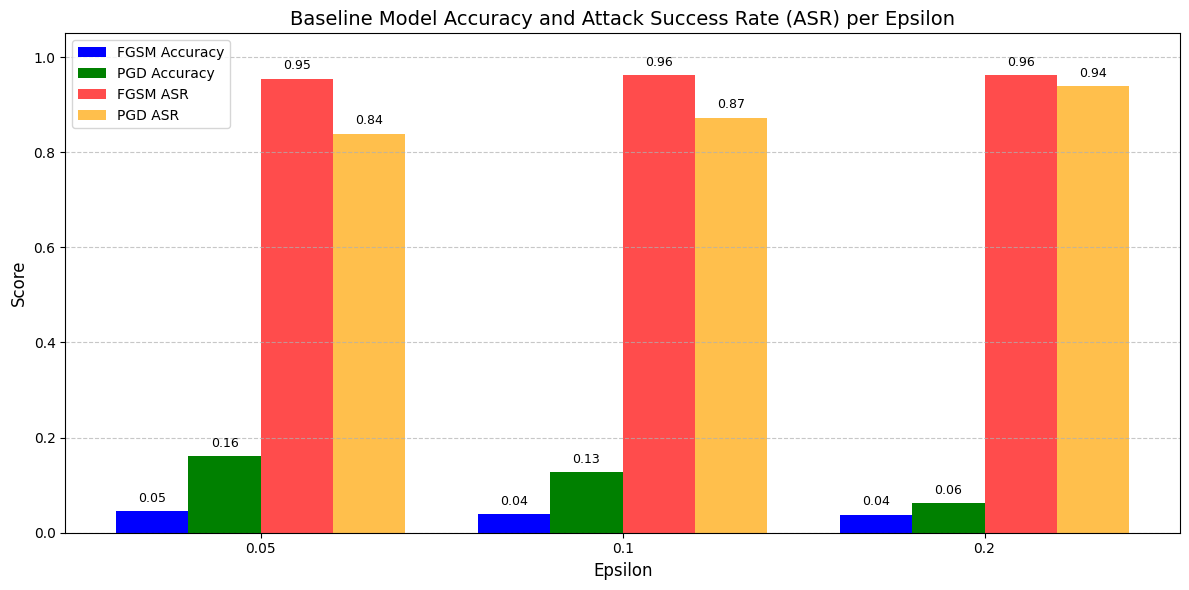

In [46]:
epsilons = sorted([float(e) for e in baseline_results['epsilons'].keys()])
n_eps = len(epsilons)

# Prepare data
fgsm_acc = [baseline_results['epsilons'][str(e)]['fgsm']['acc'] for e in epsilons]
pgd_acc  = [baseline_results['epsilons'][str(e)]['pgd']['acc']  for e in epsilons]
fgsm_asr = [baseline_results['epsilons'][str(e)]['fgsm']['asr'] for e in epsilons]
pgd_asr  = [baseline_results['epsilons'][str(e)]['pgd']['asr']  for e in epsilons]

bar_width = 0.2
x = np.arange(n_eps)

fig, ax = plt.subplots(figsize=(12,6))

# Plot Accuracy bars
ax.bar(x - 1.5*bar_width, fgsm_acc, width=bar_width, color='blue', label='FGSM Accuracy')
ax.bar(x - 0.5*bar_width, pgd_acc, width=bar_width, color='green', label='PGD Accuracy')

# Plot ASR bars
ax.bar(x + 0.5*bar_width, fgsm_asr, width=bar_width, color='red', alpha=0.7, label='FGSM ASR')
ax.bar(x + 1.5*bar_width, pgd_asr, width=bar_width, color='orange', alpha=0.7, label='PGD ASR')

# Labels and aesthetics
ax.set_xlabel('Epsilon', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline Model Accuracy and Attack Success Rate (ASR) per Epsilon', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([str(e) for e in epsilons])
ax.set_ylim(0, 1.05)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: show values on top of bars
for i in range(n_eps):
    ax.text(x[i]-1.5*bar_width, fgsm_acc[i]+0.02, f'{fgsm_acc[i]:.2f}', ha='center', fontsize=9)
    ax.text(x[i]-0.5*bar_width, pgd_acc[i]+0.02, f'{pgd_acc[i]:.2f}', ha='center', fontsize=9)
    ax.text(x[i]+0.5*bar_width, fgsm_asr[i]+0.02, f'{fgsm_asr[i]:.2f}', ha='center', fontsize=9)
    ax.text(x[i]+1.5*bar_width, pgd_asr[i]+0.02, f'{pgd_asr[i]:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Observations and Conclusions
- The baseline XGBoost binary model is highly vulnerable to simple FGSM attacks: even very small perturbations completely bypass detection.

- PGD attacks are also successful but slightly less effective, possibly due to hyperparameters (step size, iterations) that could be tuned for stronger transfer attacks.

- This clearly demonstrates the need for adversarial training or other defenses, because the detection rate can drop from ~99% to <2% under FGSM.

## Adversarial Training (FGSM augmentation)
We augment training with FGSM samples generated from malicious training flows (using the largest ε) and retrain XGBoost.


In [47]:
# Prepare adversarial training samples
X_train_malicious = X_train_scaled[y_train == 1]
y_train_malicious_true = y_train[y_train == 1]
eps_train = max(CONFIG['EPSILONS'])
X_adv_train = generate_fgsm_samples(surrogate, X_train_malicious, np.zeros(len(X_train_malicious)), epsilon=eps_train)

# Augment and shuffle
X_train_robust = np.concatenate([X_train_scaled, X_adv_train])
y_train_robust = np.concatenate([y_train, y_train_malicious_true])
X_train_robust, y_train_robust = sk_shuffle(X_train_robust, y_train_robust, random_state=CONFIG['RANDOM_STATE'])

print('Training robust XGBoost...')
if CONFIG['USE_SCALE_POS_WEIGHT']:
    robust_neg_count = (y_train_robust == 0).sum()
    robust_pos_count = (y_train_robust == 1).sum()
    robust_scale_weight = robust_neg_count / robust_pos_count
else:
    robust_scale_weight = None

robust_xgb = XGBClassifier(scale_pos_weight=robust_scale_weight, eval_metric='logloss', n_jobs=-1, random_state=CONFIG['RANDOM_STATE'])
robust_xgb.fit(X_train_robust, y_train_robust)
print('Robust training complete')


Training robust XGBoost...
Robust training complete


In [48]:
# Evaluate robust model on clean test set
y_pred_robust_clean = robust_xgb.predict(X_test_scaled)
acc_robust_clean = accuracy_score(y_test, y_pred_robust_clean)
print(f'Robust model accuracy on clean test: {acc_robust_clean*100:.2f}%')
print(classification_report(y_test, y_pred_robust_clean, digits=4))


Robust model accuracy on clean test: 99.87%
              precision    recall  f1-score   support

           0     0.9930    0.9905    0.9918      2853
           1     0.9992    0.9994    0.9993     32465

    accuracy                         0.9987     35318
   macro avg     0.9961    0.9950    0.9955     35318
weighted avg     0.9987    0.9987    0.9987     35318



In [49]:
# Evaluate robust model on adversarial test sets and mixed set
robust_results = {'epsilons': {}}
for eps in CONFIG['EPSILONS']:
    X_adv_fgsm = adv_collections[str(eps)]['fgsm']
    X_adv_pgd = adv_collections[str(eps)]['pgd']
    y_pred_fgsm = robust_xgb.predict(X_adv_fgsm)
    y_pred_pgd = robust_xgb.predict(X_adv_pgd)
    acc_fgsm = accuracy_score(y_test_malicious, y_pred_fgsm)
    acc_pgd = accuracy_score(y_test_malicious, y_pred_pgd)
    asr_fgsm = attack_success_rate(y_test_malicious, y_pred_fgsm)
    asr_pgd = attack_success_rate(y_test_malicious, y_pred_pgd)
    # Mixed set (adv malicious + clean benign) - using FGSM adversarials for mixed test
    X_mixed = np.concatenate([X_adv_fgsm, X_test_scaled[y_test == 0]])
    y_mixed = np.concatenate([np.ones(len(X_adv_fgsm), dtype=int), np.zeros((y_test == 0).sum(), dtype=int)])
    y_pred_mixed = robust_xgb.predict(X_mixed)
    mixed_acc = accuracy_score(y_mixed, y_pred_mixed)
    robust_results['epsilons'][str(eps)] = {
        'fgsm': {'acc': float(acc_fgsm), 'asr': float(asr_fgsm)},
        'pgd': {'acc': float(acc_pgd), 'asr': float(asr_pgd)},
        'mixed_acc': float(mixed_acc)
    }
    print(f'eps={eps}: robust FGSM acc={acc_fgsm:.4f}, ASR={asr_fgsm:.4f}; PGD acc={acc_pgd:.4f}, ASR={asr_pgd:.4f}; mixed_acc={mixed_acc:.4f}')


eps=0.05: robust FGSM acc=1.0000, ASR=0.0000; PGD acc=0.9675, ASR=0.0325; mixed_acc=0.9992
eps=0.1: robust FGSM acc=1.0000, ASR=0.0000; PGD acc=0.9501, ASR=0.0499; mixed_acc=0.9992
eps=0.2: robust FGSM acc=1.0000, ASR=0.0000; PGD acc=0.9362, ASR=0.0638; mixed_acc=0.9992


## Plot: Post-Adversarial Training

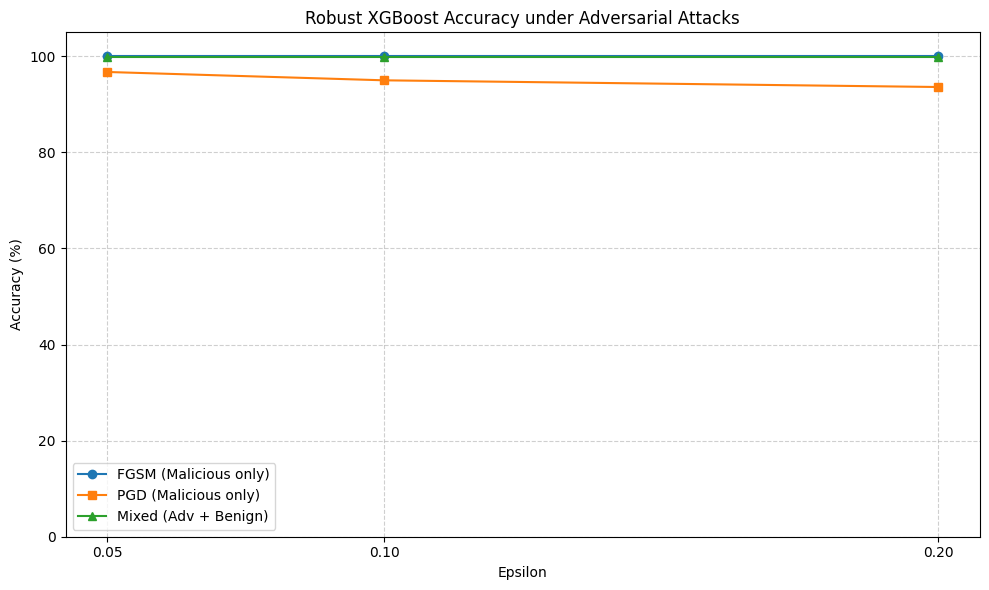

In [50]:
# Prepare data for plotting
epsilons = sorted([float(e) for e in robust_results['epsilons'].keys()])
fgsm_acc = [robust_results['epsilons'][str(e)]['fgsm']['acc'] for e in epsilons]
pgd_acc = [robust_results['epsilons'][str(e)]['pgd']['acc'] for e in epsilons]
mixed_acc = [robust_results['epsilons'][str(e)]['mixed_acc'] for e in epsilons]

# Convert to percentages
fgsm_acc_pct = [a * 100 for a in fgsm_acc]
pgd_acc_pct = [a * 100 for a in pgd_acc]
mixed_acc_pct = [a * 100 for a in mixed_acc]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epsilons, fgsm_acc_pct, marker='o', label='FGSM (Malicious only)')
plt.plot(epsilons, pgd_acc_pct, marker='s', label='PGD (Malicious only)')
plt.plot(epsilons, mixed_acc_pct, marker='^', label='Mixed (Adv + Benign)')

plt.title('Robust XGBoost Accuracy under Adversarial Attacks')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.xticks(epsilons)
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Baseline vs. Robust Results

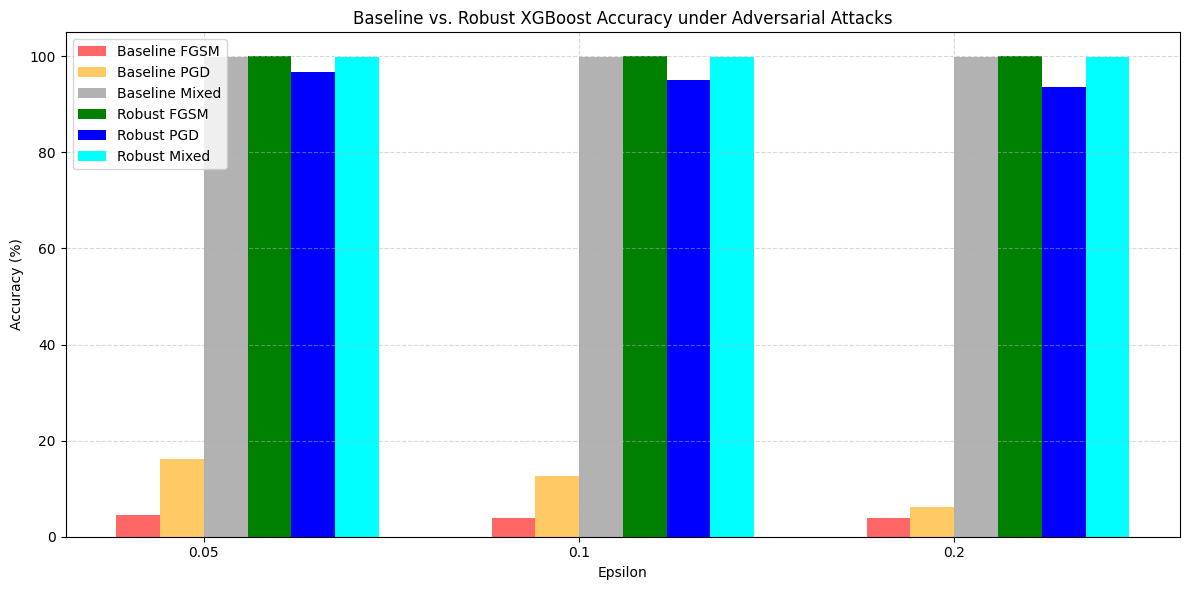

In [51]:
# Attack types
attack_types = ['FGSM', 'PGD', 'Mixed']
x = np.arange(len(CONFIG['EPSILONS']))  # positions for epsilons
width = 0.35  # width of bars

# Prepare baseline data
baseline_fgsm_acc = [baseline_results['epsilons'][str(e)]['fgsm']['acc']*100 for e in CONFIG['EPSILONS']]
baseline_pgd_acc  = [baseline_results['epsilons'][str(e)]['pgd']['acc']*100 for e in CONFIG['EPSILONS']]
baseline_mixed_acc = [baseline_results['clean_acc']*100 for _ in CONFIG['EPSILONS']]  # baseline mixed = clean

# Prepare robust data
robust_fgsm_acc = [robust_results['epsilons'][str(e)]['fgsm']['acc']*100 for e in CONFIG['EPSILONS']]
robust_pgd_acc  = [robust_results['epsilons'][str(e)]['pgd']['acc']*100 for e in CONFIG['EPSILONS']]
robust_mixed_acc = [robust_results['epsilons'][str(e)]['mixed_acc']*100 for e in CONFIG['EPSILONS']]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for i, eps in enumerate(CONFIG['EPSILONS']):
    ax.bar(i - width/2, baseline_fgsm_acc[i], width/3, label='Baseline FGSM' if i==0 else "", color='red', alpha=0.6)
    ax.bar(i - width/2 + width/3, baseline_pgd_acc[i], width/3, label='Baseline PGD' if i==0 else "", color='orange', alpha=0.6)
    ax.bar(i - width/2 + 2*width/3, baseline_mixed_acc[i], width/3, label='Baseline Mixed' if i==0 else "", color='gray', alpha=0.6)

    ax.bar(i + width/2, robust_fgsm_acc[i], width/3, label='Robust FGSM' if i==0 else "", color='green')
    ax.bar(i + width/2 + width/3, robust_pgd_acc[i], width/3, label='Robust PGD' if i==0 else "", color='blue')
    ax.bar(i + width/2 + 2*width/3, robust_mixed_acc[i], width/3, label='Robust Mixed' if i==0 else "", color='cyan')

# Labels
ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Baseline vs. Robust XGBoost Accuracy under Adversarial Attacks')
ax.set_xticks(x)
ax.set_xticklabels(CONFIG['EPSILONS'])
ax.set_ylim(0, 105)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Confusion Matrix

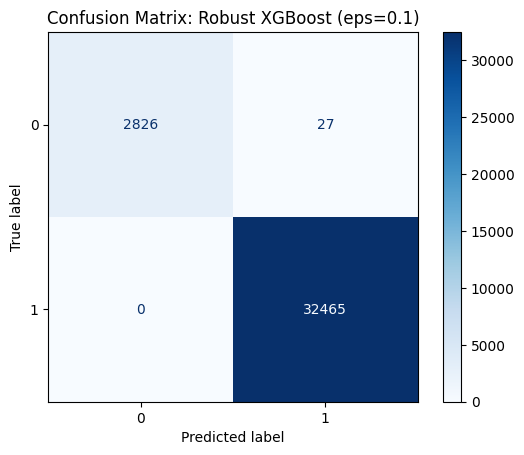

In [52]:
y_true = y_mixed  # combined adversarial + benign
y_pred = robust_xgb.predict(X_mixed)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Robust XGBoost (eps=0.1)")
plt.show()

### AUC-ROC Curves

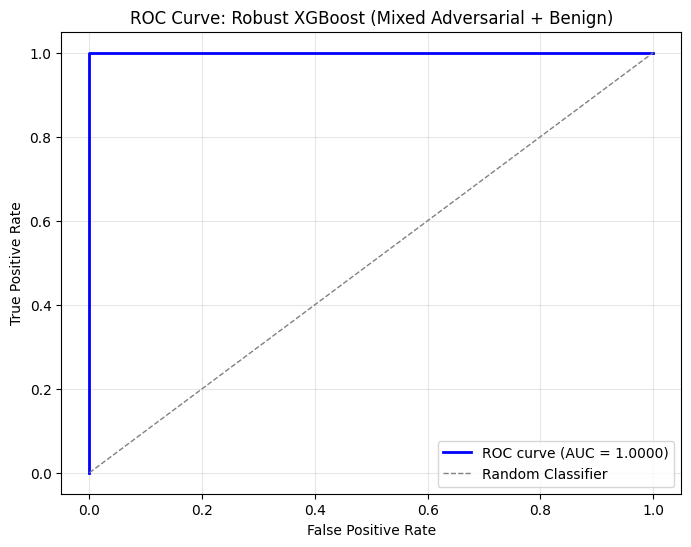

In [53]:
# Mixed set: adversarial malicious + clean benign
y_true = y_mixed
y_pred_proba = robust_xgb.predict_proba(X_mixed)[:, 1]  # probability for class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Robust XGBoost (Mixed Adversarial + Benign)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Save Results & Artifacts
Saves JSON results and the robust XGBoost model to the ARTIFACTS directory in Drive.


Saved experiment summary to /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/adversarial_experiment.json
Saved plot to /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/adversarial_comparison_0.05.png
Saved plot to /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/adversarial_comparison_0.1.png
Saved plot to /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/adversarial_comparison_0.2.png
Saved robust XGBoost to /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/robust_binary_xgboost.json


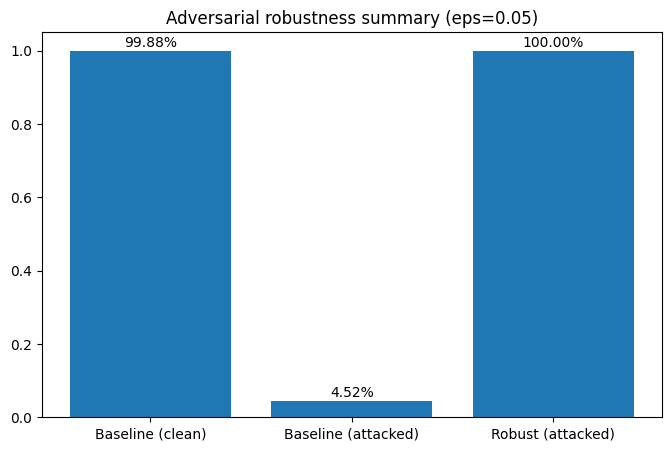

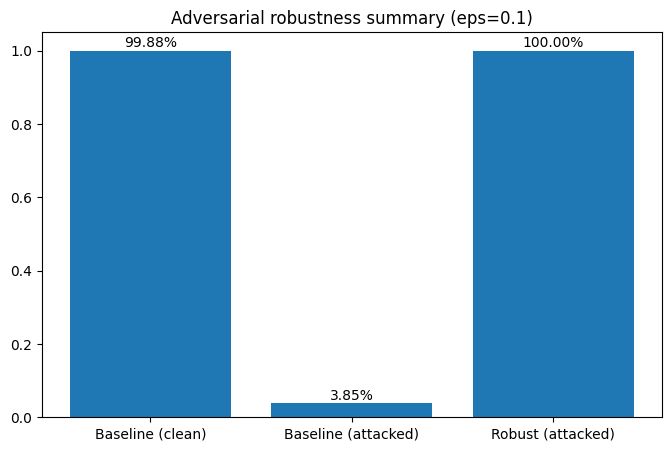

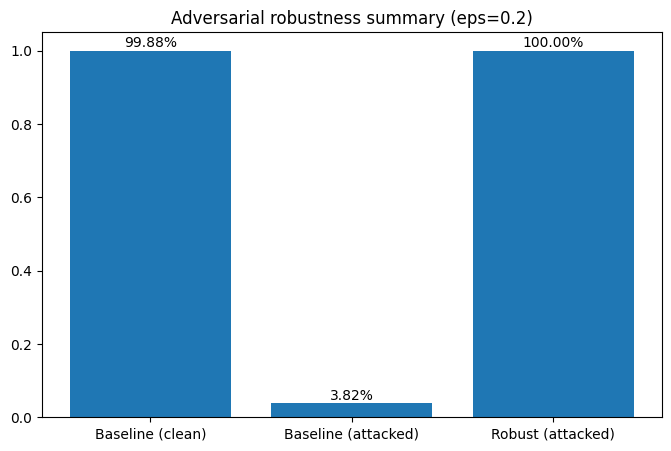

In [58]:
# Consolidate results and save
summary = {
    'config': CONFIG,
    'baseline_clean_acc': acc_xgb_normal,
    'baseline_results': baseline_results,
    'robust_clean_acc': acc_robust_clean,
    'robust_results': robust_results
}
with open(PATHS['EXPERIMENT_RESULTS'], 'w') as f:
    json.dump(summary, f, indent=2)
print(f'Saved experiment summary to {PATHS['EXPERIMENT_RESULTS']}')

# Save plot (simple summary for epsilons)
if CONFIG['SAVE_PLOTS']:
    # Save for every epsilon
    for eps in CONFIG['EPSILONS']:
      baseline_att = baseline_results['epsilons'][str(eps)]['fgsm']['acc']
      robust_att = robust_results['epsilons'][str(eps)]['fgsm']['acc']
      labels = ['Baseline (clean)', 'Baseline (attacked)', 'Robust (attacked)']
      scores = [summary['baseline_clean_acc'], baseline_att, robust_att]
      plt.figure(figsize=(8,5))
      bars = plt.bar(labels, scores)
      plt.ylim(0,1.05)
      for bar in bars:
          yval = bar.get_height()
          plt.text(bar.get_x()+bar.get_width()/2, yval+0.01, f'{yval*100:.2f}%', ha='center')
      plt.title(f'Adversarial robustness summary (eps={eps})')
      img_path = PATHS['EXPERIMENT_PLOT'].replace('.png', f'_{eps}.png')
      plt.savefig(img_path)
      print(f'Saved plot to {img_path}')

# Save robust model
robust_xgb.save_model(PATHS['ROBUST_MODEL_OUT'])
print(f'Saved robust XGBoost to {PATHS['ROBUST_MODEL_OUT']}')
